<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 

# Transformers & Preprocessing

_Author: Jeff Hale_

![transformer](images/transformer.jpeg)

Image sources: pixabay.com

---

### Learning Objectives
- Understand how to use which scikit-learn transformers
- Fill missing values using SimpleImputer
- Encode categorical features with OneHotEncoder
- Standardize features with StandardScaler
- Add new features with PolynomialFeatures
- Reduce the number of features with RFE 


### Prerequisites
- Familiarity with Python and pandas
- Understand the machine learning workflow
- Scikit-learn basics

You have future lessons on feature engineering and interpetation. This lesson is designed to give you familiarity with scikit-learn transformers and the tools you need to create models that perform well.

## Imports

In [2]:
# pip install sklearn -U

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn import __version__
__version__

'1.0'

#### Load modified tips dataset

One waiter's tips. Data dictionary [here](https://vincentarelbundock.github.io/Rdatasets/doc/reshape2/tips.html).

In [4]:
tips = pd.read_csv('data/tips_miss.csv', index_col=0)

#### Peek and get info

In [5]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,Male,No,Sun,Dinner,3.0
2,21.01,3.50,Male,No,NaN,Dinner,3.0
3,23.68,3.31,Male,NaN,Sun,Dinner,2.0
4,24.59,3.61,Female,No,Sun,Dinner,4.0


In [8]:
tips.drop_duplicates().shape

(244, 7)

In [6]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  220 non-null    float64
 1   tip         244 non-null    float64
 2   sex         220 non-null    object 
 3   smoker      220 non-null    object 
 4   day         220 non-null    object 
 5   time        220 non-null    object 
 6   size        220 non-null    float64
dtypes: float64(3), object(4)
memory usage: 15.2+ KB


### Fix any obvious problems, rename columns, etc.

#### Set up X and y

In [9]:
tips.head(2)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,Male,No,Sun,Dinner,3.0


In [10]:
X = tips.drop('tip', axis = 1)
y = tips['tip']

In [11]:
X.shape

(244, 6)

In [12]:
y.shape

(244,)

#### train_test_split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

From now on, you deal with the training data.

In [15]:
import seaborn as sns

#### Heatmap correlation plot

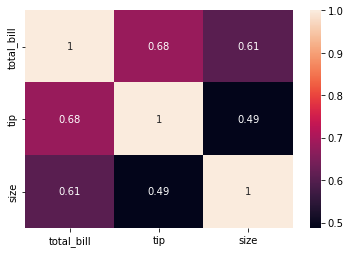

In [17]:
sns.heatmap(tips.corr(), annot = True)

#### Pairplot

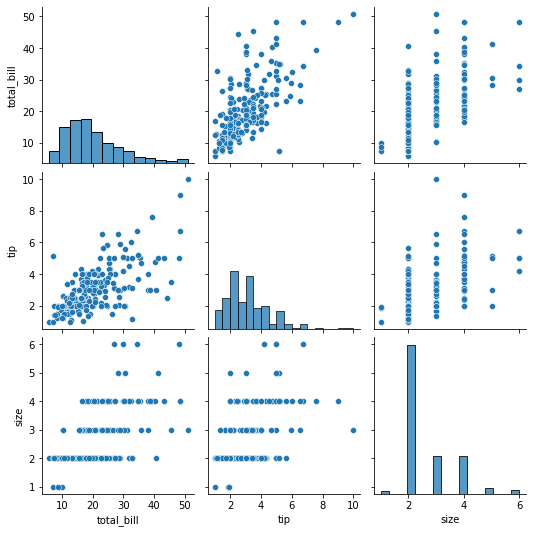

In [18]:
sns.pairplot(tips)

## Rule 1: the test set is off limits 
Don't do anything to it that you couldn't do to new data.
For example don't one-hot encode a value that only shows up in the test-set.

### Let's jump into transformations you can do to your features.

---

## 1. Fill missing values 

![puzzle pieces](images/puzzle.jpeg)

You often want to to deal with missing data early so you can do other preprocessing. Dropping rows can be fine if you have a lot of other data. Same goes for dropping columns if most values are missing and there is not much unique signal in the column. How might you know if a column has little signal in it?

If you can figure out why the values are missing, you might want to fill the values accordingly. For example, maybe people who didn't respond to a survey question about owning a car don't own a car.

Often, though, you don't know why the data are missing.

#### Options:

- If continuous numeric data, fill with the mean, median, mode or a constant you choose.
- If nominal categorical data, fill with the mode or a constant you choose.

This is called _imputing_ missing values. scikit-learn's SimpleImputer can help us.

(Ignore forward or backward filling time series data and adding sentinel values for non-linear algorithms for now).

All of these options reduce the variance in your data, so they are not ideal.

All scikit-learn transformers should be fit on the training data and transform the training data. They should ONLY transform the test data. Remember Rule 1! 😀

In [20]:
from sklearn.impute import SimpleImputer

#### Instantiate

In [21]:
si = SimpleImputer(strategy='most_frequent')

#### Fit on X_train

In [22]:
si.fit(X_train)

SimpleImputer(strategy='most_frequent')

In [24]:
si.statistics_

array([13.42, 'Male', 'No', 'Sat', 'Dinner', 2.0], dtype=object)

#### Transform X_train and save the result

In [26]:
X_tr_no_missing = si.transform(X_train)

In [28]:
pd.DataFrame(X_tr_no_missing).isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

#### Transform (no fit) X_test and save the result

In [29]:
X_ts_no_missing = si.transform(X_test)

#### `Strategy=most_frequent` will work on non-numeric columns. Mean won't.⚠️ 

In [31]:
si2 = SimpleImputer(strategy='mean')
si2.fit_transform(X_train)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Female'

Check out other SimpleImputer options.

Iterative imputing, in which an algorithm is fit to the data that is not missing, is likely to create values that help your model perform better. This process can be slow. IterativeImputer is an experimental class in scikit-learn as of this writing. 

KNNImputer often performs better than SimpleImputer. It can also be a little slow. You'll learn about KNN classification soon, and this transformer is similar.

You can evaluate different missing value strategies. GridSearching with Pipelines makes this process much easier, so we'll put it off until we see those techniques.

Adding a column to indicate that a value was missing (a missing indicator) does not appear to help model performance, in most cases. This is an option with most imputation transformers.

⚠️ Interpretation becomes a bit tricky when you create data. Just note what you did.
### Always communicate how you treated missing data!

---
## 2. Encode categorical features

![binary code](images/binary.jpeg)

Our data generally needs to be numeric. If you data is nominal categorical data, one-hot-encoding (dummy encoding) is the most common method. 

We generally don't want to encode a column into numeric data before splitting it because that would violate Rule 1. 

If there were 50 categories and some were rare, our model might see one in the real world that it had never seen before. That might make our model perform worse in the real world (assuming that feature is important) We don't want our model to give us test set results that would are overly optimistic.

Generally, if there aren't any values that show up only a few times in a column, you can one-hot encode your columns before creating a test set, and not worry about overstating your test set scores.

In [32]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,Male,No,Sun,Dinner,3.0
2,21.01,3.50,Male,No,NaN,Dinner,3.0
3,23.68,3.31,Male,NaN,Sun,Dinner,2.0
4,24.59,3.61,Female,No,Sun,Dinner,4.0


#### Instantiate, fit and transform X_train, transform (no fit) X_test

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [45]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)

In [43]:
X_train_ohe = ohe.fit_transform(X_train[['sex']])

In [44]:
pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out())

,sex_Male,sex_nan
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,1.0
4,0.0,0.0
...,...,...
178,1.0,0.0
179,0.0,0.0
180,0.0,0.0
181,1.0,0.0


## `make_column_transformer`
If we want to apply a transformation to only some of our X columns, we need to specify which columns with `make_column_transformer`.

In [46]:
from sklearn.compose import make_column_transformer

In [47]:
tips.head(1)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0


In [49]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)

In [51]:
smart_encoder = make_column_transformer((ohe, ['sex', 'smoker', 'day', 'time']),
                           remainder = 'passthrough')

In [56]:
X_tr_no_miss_df = pd.DataFrame(X_tr_no_missing, columns=X.columns)
X_tr_no_miss_df.head()

,total_bill,sex,smoker,day,time,size
0,17.31,Female,No,Sun,Dinner,2
1,23.33,Male,Yes,Sun,Dinner,2
2,16.27,Female,Yes,Fri,Lunch,2
3,20.23,Male,No,Sat,Dinner,2
4,20.92,Female,No,Sat,Dinner,2


In [58]:
ohe_tr = smart_encoder.fit_transform(X_tr_no_miss_df)

In [59]:
pd.DataFrame(ohe_tr, columns=smart_encoder.get_feature_names_out())

,onehotencoder__sex_Male,onehotencoder__smoker_Yes,onehotencoder__day_Fri,onehotencoder__day_Sat,onehotencoder__day_Sun,onehotencoder__day_Thur,onehotencoder__time_Lunch,remainder__total_bill,remainder__size
0,0,0,0,0,1,0,0,17.31,2
1,1,1,0,0,1,0,0,23.33,2
2,0,1,1,0,0,0,1,16.27,2
3,1,0,0,1,0,0,0,20.23,2
4,0,0,0,1,0,0,0,20.92,2
...,...,...,...,...,...,...,...,...,...
178,1,1,0,1,0,0,0,20.49,2
179,0,0,0,1,0,0,0,13.42,2
180,0,1,1,0,0,0,0,5.75,2
181,1,0,0,0,1,0,0,13.42,2


### Convert to a DataFrame

---
## 3. StandardScaler
You've seen how to make sure each feature has  0 mean and 1 standard-deviation. 

It's a good idea to standardize and scale any model that uses regularization. Then one feature with large values won't overwhelm other features with small values.

#### Before:
![plots of distributions](images/orig_dists.png)

#### After:
![post standard scaled dists](images/after_ss.png)

Plots from Jeff's [post on standardizing and scaling options](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02?sk=a82c5faefadd171fe07506db4d4f29db).

If a feature doesn't look very normal after standard scaling, you could try `QuantileTransformer(output_distribution='normal')` to make the distribution more normal.

#### Instantiate, fit and transform X_train, transform (no fit) X_test

---
## 4. PolynomialFeatures

![](images/fireworks.jpeg)

You've seen how to add interactions and polynomials to create more features. This can help capture non-linear relationships for a regression model.

Features *a* and *b* expand into features `1, a, b, a^2, ab, b^2`

Watch out for a feature explosion! 🧨

Let's do this now so we can then see how to reduce the number of features later.

#### Instantiate, fit and transform X_train, transform (only) X_test

---
## 5.Feature Elimination with RFE 

![](images/rubbish.jpeg)

You can drop features manually, but that's not ideal if you have lots and lots of features. 

If you want to try out a model with fewer features you can automatically drop what are probably the least useful features.

RFE stands for *Recursive Feature Elimination*. It takes an estimator and the number or proportion of features to select. It keeps the ones with the highest coefficients (or highest features importances for models that don't have coefficients).

You have to pass it the estimator to use. If the estimator works better when you have more observations than features - as linear regression does, consider that fact.

#### Instantiate, fit and transform X_train, transform X_test

---
# Transform *y*

All of the above transformers change your X (features, independent variables).

You can transform y, too. It's fairly common to try to make the y more normal in a regression problem. Often a log transform works.

Scikit-learn's TransformedTargetRegressor is what you want.

---

You don't have to do all these things. In fact, usually you won't do all of them.

### After you've done your transformations, it's time to model! ⭐️

You'll learn how to try lots of transformer combinations when you combine GridSearch and Pipelines soon.

## Summary

You've seen how to use scikit-learn transformers to 

- Fill missing values using SimpleImputer
- Encode categorical features with OneHotEncoder
- Standardize features with StandardScaler
- Add new features with PolynomialFeatures
- Reduce the number of features with RFE 
- Transform y

Read the scikit-learn docs for each of the transformers when you get a chance. 

## Check for understanding

- When would you use each of the above transformer classes?
- What's the difference between fitting and transforming?